# Unified Model with Integrated Bot (Highly Symmetric Case): $K_2$

James Yu, 22 August 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from sympy import *
np.set_printoptions(suppress=True) # disable scientific notation for readability

In [2]:
def infinite_solution(A_n, A_c, delta, c, x_0, z):
    n = len(x_0)
    eps = np.finfo(np.float64).eps
    I = np.identity(n)
    O = np.zeros((n, n))
    
    Q = np.block([
        [I, O], 
        [O, O]
    ])
    A = np.block([
        [A_n, A_c], 
        [O, I]
    ])
    B = np.block([
        [I],
        [O]
    ])
    K_t = Q
    K_sequence = [K_t]
    
    while True: # generate solution matrices; note I divide delta into the inverse term for simplification
        K_t_new = Q + delta * A.T @ (K_t - K_t @ B @ inv(B.T @ K_t @ B + c * I / delta) @ B.T @ K_t) @ A
        K_sequence.insert(0, K_t_new)
        if np.allclose(K_t, K_t_new, rtol = eps, atol = eps): break
        K_t = K_t_new

    chi_var = np.block([
        [x_0], 
        [z]
    ])
    chi_ts = [chi_var]
    r_ts = []
    K_ss = K_sequence[0]
    L_ss = -inv(B.T @ K_ss @ B + c * I / delta) @ B.T @ K_ss @ A
    
    payoff = 0
    stage_payoffs = []
    discounted_stage_payoffs = []
    cumulative_payoffs = []
    
    i = 0
    while True:
        r_t = L_ss @ chi_var
        r_ts.append(r_t)
        p = -(chi_var.T @ Q @ chi_var + c * r_t.T @ r_t).item()
        payoff += delta**i * p
        stage_payoffs.append(p)
        discounted_stage_payoffs.append(delta**i * p)
        cumulative_payoffs.append(payoff)
        chi_var_new = A @ chi_var + B @ r_t
        chi_ts.append(chi_var_new)
        if np.allclose(chi_var, chi_var_new, rtol = eps, atol = eps): break
        chi_var = chi_var_new
        i += 1
        
    return chi_ts, K_ss #, r_ts, stage_payoffs, discounted_stage_payoffs, cumulative_payoffs, K_ss, L_ss

# Prelim expressions

In [3]:
x, d, z, r, delta, c, k1, k2, k3 = symbols("x d z r delta c k_1 k_2 k_3")
xprime = (1 - d) * x + d * z + r # the next period function
v_x = -(x**2) - (c * r**2) - (delta * k1 * xprime**2) - (2 * delta * k2 * xprime * z) - (delta * k3)
r_star = solve(diff(v_x, r), r)[0]
simplify(expand(r_star)) # r_star

delta*(d*k_1*x - d*k_1*z - k_1*x - k_2*z)/(c + delta*k_1)

In [4]:
g = symbols("g")
solve(-delta*k1**2 + k1*g + c, k1)[1].subs(g, delta-c+c*delta*(1-d)**2) # k1

(c*delta*(1 - d)**2 - c + delta + sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2))/(2*delta)

In [5]:
solve(simplify((c*delta*(1-d)*(d*k1+k2))/(c+delta*k1) - k2), k2)[0] # k2

c*d*delta*k_1*(1 - d)/(c*d*delta - c*delta + c + delta*k_1)

# Validate the $k_2$ expression numerically (for three examples)

### 1

In [6]:
K1 = solve(-delta*k1**2 + k1*g + c, k1)[1].subs(g, delta-c+c*delta*(1-d)**2).subs(delta, 0.9).subs(d, 0.5).subs(c, 1)
K1 # k1, but using different name to avoid collision

1.12582204832258

In [7]:
K2 = solve(simplify((c*delta*(1-d)*(d*k1+k2))/(c+delta*k1) - k2), k2)[0].subs(k1, K1).subs(delta, 0.9).subs(d, 0.5).subs(c, 1)
K2 # same here

0.162041648264928

In [8]:
A_6_n = 0.5 * np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])
A_6_c = np.diag([0.5, 0.5, 0.5])
x_0 = np.array([[10.0, 5.0, -20.0]], ndmin = 2).T
_, K_test = infinite_solution(A_6_n, A_6_c, 0.9, 1, x_0, np.array([[5.0, 5.0, 5.0]], ndmin = 2).T)
sum(K_test[0:3, 0:3]) # k1

array([1.12582205, 1.12582205, 1.12582205])

In [9]:
sum(K_test[0:3, 3:6]) # k2

array([0.16204165, 0.16204165, 0.16204165])

### 2

In [10]:
K1_2 = solve(-delta*k1**2 + k1*g + c, k1)[1].subs(g, delta-c+c*delta*(1-d)**2).subs(delta, 0.3).subs(d, 0.5).subs(c, 1)
K1_2

1.06033304260491

In [11]:
solve(simplify((c*delta*(1-d)*(d*k1+k2))/(c+delta*k1) - k2), k2)[0].subs(k1, K1_2).subs(delta, 0.3).subs(d, 0.5).subs(c, 1)

0.0680806301971238

In [12]:
_, K_test_2 = infinite_solution(A_6_n, A_6_c, 0.3, 1, x_0, np.array([[5.0, 5.0, 5.0]], ndmin = 2).T)
sum(K_test_2[0:3, 0:3]) # k1

array([1.06033304, 1.06033304, 1.06033304])

In [13]:
sum(K_test_2[0:3, 3:6]) # k2

array([0.06808063, 0.06808063, 0.06808063])

### 3

In [14]:
A_7_n = 0.2 * np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])
A_7_c = np.diag([0.8, 0.8, 0.8])

In [15]:
K1_3 = solve(-delta*k1**2 + k1*g + c, k1)[1].subs(g, delta-c+c*delta*(1-d)**2).subs(delta, 0.3).subs(d, 0.8).subs(c, 0.3)
K1_3

1.00601799983800

In [16]:
solve(simplify((c*delta*(1-d)*(d*k1+k2))/(c+delta*k1) - k2), k2)[0].subs(k1, K1_3).subs(delta, 0.3).subs(d, 0.8).subs(c, 0.3)

0.0248141918503549

In [17]:
_, K_test_3 = infinite_solution(A_7_n, A_7_c, 0.3, 0.3, x_0, np.array([[5.0, 5.0, 5.0]], ndmin = 2).T)
sum(K_test_3[0:3, 0:3]) # k1

array([1.006018, 1.006018, 1.006018])

In [18]:
sum(K_test_3[0:3, 3:6]) # k2

array([0.02481419, 0.02481419, 0.02481419])

# $k_1/c$ in $c$

In [19]:
k1_solved = solve(-delta*k1**2 + k1*g + c, k1)[1].subs(g, delta-c+c*delta*(1-d)**2)
k1_solved # from before

(c*delta*(1 - d)**2 - c + delta + sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2))/(2*delta)

In [20]:
expand(k1_solved/c)

d**2/2 - d + 1/2 - 1/(2*delta) + 1/(2*c) + sqrt(c**2*d**4*delta**2 - 4*c**2*d**3*delta**2 + 6*c**2*d**2*delta**2 - 2*c**2*d**2*delta - 4*c**2*d*delta**2 + 4*c**2*d*delta + c**2*delta**2 - 2*c**2*delta + c**2 + 2*c*d**2*delta**2 - 4*c*d*delta**2 + 2*c*delta**2 + 2*c*delta + delta**2)/(2*c*delta)

The $1/2c$ term decreases in $c$, so we examine the square root:

In [21]:
expand(sqrt(4*c*delta + (delta-c+c*delta*(1-d)**2)**2)/(2*c*delta))

sqrt(c**2*d**4*delta**2 - 4*c**2*d**3*delta**2 + 6*c**2*d**2*delta**2 - 2*c**2*d**2*delta - 4*c**2*d*delta**2 + 4*c**2*d*delta + c**2*delta**2 - 2*c**2*delta + c**2 + 2*c*d**2*delta**2 - 4*c*d*delta**2 + 2*c*delta**2 + 2*c*delta + delta**2)/(2*c*delta)

which is just:

In [22]:
sqrt(4*c*delta + (delta-c+c*delta*(1-d)**2)**2)/(2*c*delta)

sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2)/(2*c*delta)

which simplifies to the following since $2c\delta > 0$:

In [23]:
sqrt(1/(c*delta) + ((1-d)**2/2 - 1/(2*delta) + 1/(2*c))**2)

sqrt(((1 - d)**2/2 - 1/(2*delta) + 1/(2*c))**2 + 1/(c*delta))

Expanding:

In [24]:
expand(sqrt(1/(c*delta) + ((1-d)**2/2 - 1/(2*delta) + 1/(2*c))**2))

sqrt(d**4/4 - d**3 + 3*d**2/2 - d**2/(2*delta) - d + d/delta + 1/4 - 1/(2*delta) + 1/(4*delta**2) + d**2/(2*c) - d/c + 1/(2*c) + 1/(2*c*delta) + 1/(4*c**2))

The terms with $c$ are:

In [25]:
d**2/(2*c) - d/c + 1/(2*c) + 1/(2*c*delta) + 1/(4*c**2)

d**2/(2*c) - d/c + 1/(2*c) + 1/(2*c*delta) + 1/(4*c**2)

and the first three combine together, which changes the expression to:

In [26]:
(1-d)**2 / (2*c) + 1/(2*c*delta) + 1/(4*c**2)

(1 - d)**2/(2*c) + 1/(2*c*delta) + 1/(4*c**2)

which is decreasing in $c$. Thus, $k_1/c$ is decreasing in $c$.

We can do some checks:

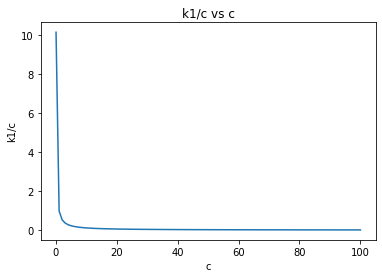

In [27]:
 # note the parameters listed here
f = lambda x: float((k1_solved/c).subs(delta, 0.9).subs(d, 0.6).subs(c, x))
plt.plot(np.linspace(0.1, 100, 100), [f(x) for x in np.linspace(0.1, 100, 100)])
plt.title("k1/c vs c")
plt.xlabel("c")
plt.ylabel("k1/c")
plt.show()

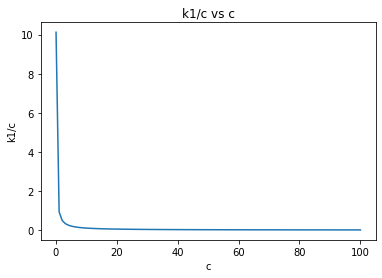

In [28]:
f2 = lambda x: float((k1_solved/c).subs(delta, 0.3).subs(d, 0.6).subs(c, x))
plt.plot(np.linspace(0.1, 100, 100), [f2(x) for x in np.linspace(0.1, 100, 100)])
plt.title("k1/c vs c")
plt.xlabel("c")
plt.ylabel("k1/c")
plt.show()

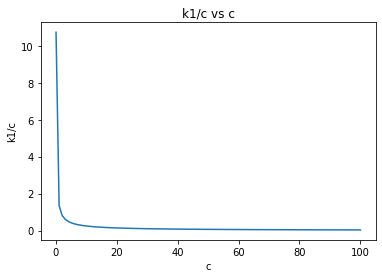

In [29]:
f3 = lambda x: float((k1_solved/c).subs(delta, 0.9).subs(d, 0.1).subs(c, x))
plt.plot(np.linspace(0.1, 100, 100), [f3(x) for x in np.linspace(0.1, 100, 100)])
plt.title("k1/c vs c")
plt.xlabel("c")
plt.ylabel("k1/c")
plt.show()

# $k_2/c$ in $c$

In [30]:
k2_solved = solve(simplify((c*delta*(1-d)*(d*k1+k2))/(c+delta*k1) - k2), k2)[0]
k2_solved/c

d*delta*k_1*(1 - d)/(c*d*delta - c*delta + c + delta*k_1)

Multiply the numerator and denominator by $1/c$:

In [31]:
dk1c = Symbol(r"\frac{\delta k_1}{c}")
(d * (1-d) * dk1c) / (d*delta - delta + 1 + dk1c)

\frac{\delta k_1}{c}*d*(1 - d)/(\frac{\delta k_1}{c} + d*delta - delta + 1)

Multiply the numerator and denominator by $c / \delta k_1$:

In [32]:
d * (1 - d) / (1 + (d*delta + (1 - delta)) / (dk1c))

d*(1 - d)/(1 + (d*delta - delta + 1)/\frac{\delta k_1}{c})

Since $\delta k_1 / c$ is decreasing in $c$, we can observe that the expression as a whole is decreasing in $c$ (as the other components are positive).

We can verify - first, that the expressions are the same:

In [33]:
simplify(expand(d * (1 - d) / (1 + (d*delta + (1 - delta)) / (delta * k1 / c))))

d*delta*k_1*(1 - d)/(c*delta*(d - 1) + c + delta*k_1)

and second, that it decreases in $c$ in practice:

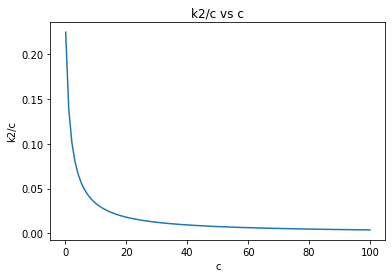

In [34]:
f4 = lambda x: float((k2_solved/c).subs(k1, k1_solved).subs(delta, 0.9).subs(d, 0.6).subs(c, x))
plt.plot(np.linspace(0.1, 100, 100), [f4(x) for x in np.linspace(0.1, 100, 100)])
plt.title("k2/c vs c")
plt.xlabel("c")
plt.ylabel("k2/c")
plt.show()

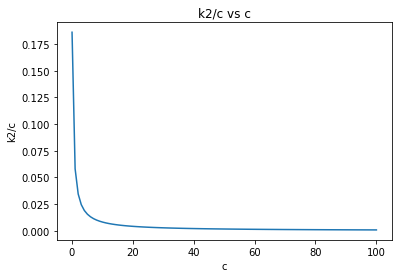

In [35]:
f5 = lambda x: float((k2_solved/c).subs(k1, k1_solved).subs(delta, 0.3).subs(d, 0.6).subs(c, x))
plt.plot(np.linspace(0.1, 100, 100), [f5(x) for x in np.linspace(0.1, 100, 100)])
plt.title("k2/c vs c")
plt.xlabel("c")
plt.ylabel("k2/c")
plt.show()

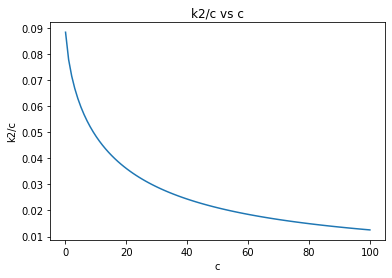

In [36]:
f6 = lambda x: float((k2_solved/c).subs(k1, k1_solved).subs(delta, 0.9).subs(d, 0.1).subs(c, x))
plt.plot(np.linspace(0.1, 100, 100), [f6(x) for x in np.linspace(0.1, 100, 100)])
plt.title("k2/c vs c")
plt.xlabel("c")
plt.ylabel("k2/c")
plt.show()

# $\delta k_1$ in $\delta$

In [37]:
delta * k1_solved

c*delta*(1 - d)**2/2 - c/2 + delta/2 + sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2)/2

The derivative of the above expression is:

In [38]:
diff(delta * k1_solved, delta)

c*(1 - d)**2/2 + (2*c + (2*c*(1 - d)**2 + 2)*(c*delta*(1 - d)**2 - c + delta)/2)/(2*sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2)) + 1/2

Let $g = c\delta(1-d)^2 - c + \delta$. Then let $g^\prime = c(1-d)^2 + 1$. This implies that we have:

$$\frac{g^\prime}{2} + \frac{2c + gg^\prime}{2\sqrt{4c\delta + g^2}}$$

$$= \frac{g^\prime}{2}(1 + \frac{g}{\sqrt{4c\delta+g^2}}) + \frac{c}{\sqrt{4c\delta+g^2}}$$

We know $g^\prime > 0$ and the fraction on the right is positive, so we look at the fraction in the middle, which is:

In [39]:
(g/sqrt(4*c*delta + g**2))

g/sqrt(4*c*delta + g**2)

If $g$ is positive, then this is positive. If $g$ is negative, then consider $\sqrt{4c\delta + g^2} - |g|$. We know that $\sqrt{g^2} - |g| = 0$ so, since $\sqrt{}$ is monotone positive and $4c\delta > 0$, it follows that $\sqrt{4c\delta + g^2} > |g|$. Thus, the magnitude of the above fraction is less than 1, and so $1 + \frac{g}{\sqrt{4c\delta+g^2}} > 0$. This implies that the derivative of $\delta k_1$ with respect to $\delta$ is always positive, and so this expression is increasing in $\delta$.

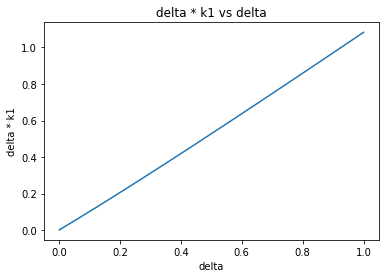

In [40]:
f7 = lambda x: float((delta * k1_solved).subs(delta, x).subs(d, 0.6).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f7(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k1 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k1")
plt.show()

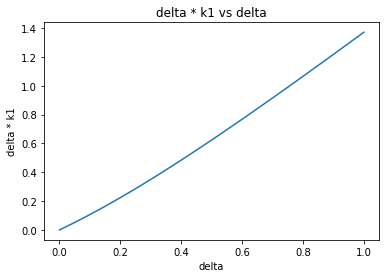

In [41]:
f8 = lambda x: float((delta * k1_solved).subs(delta, x).subs(d, 0.2).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f8(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k1 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k1")
plt.show()

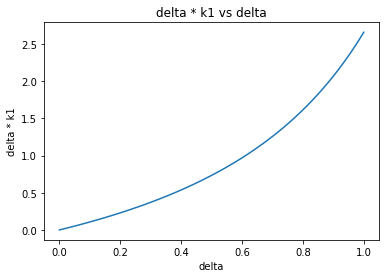

In [42]:
f9 = lambda x: float((delta * k1_solved).subs(delta, x).subs(d, 0.2).subs(c, 100))
plt.plot(np.linspace(0.001, 1, 100), [f9(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k1 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k1")
plt.show()

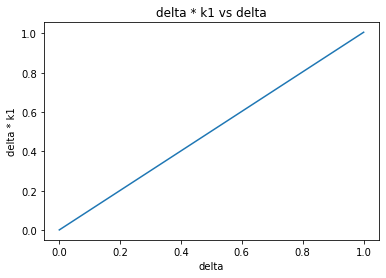

In [43]:
f10 = lambda x: float((delta * k1_solved).subs(delta, x).subs(d, 0.2).subs(c, 0.01))
plt.plot(np.linspace(0.001, 1, 100), [f10(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k1 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k1")
plt.show()

# $\delta k_2$ in $\delta$

In [44]:
delta * k2_solved

c*d*delta**2*k_1*(1 - d)/(c*d*delta - c*delta + c + delta*k_1)

Multiply the numerator and denominator by $\frac{1}{\delta k_1}$:

In [45]:
c * d * delta * (1-d) / ((c * delta * (d - 1))/(delta * k1) + c/(delta*k1) + 1)

c*d*delta*(1 - d)/(c*(d - 1)/k_1 + c/(delta*k_1) + 1)

In [46]:
(delta * k2_solved)

c*d*delta**2*k_1*(1 - d)/(c*d*delta - c*delta + c + delta*k_1)

Remove some constants on the numerator and then take the reciprocal to get:

In [47]:
1 / (delta * k2_solved / (1 - d))

(c*d*delta - c*delta + c + delta*k_1)/(c*d*delta**2*k_1)

This simplifies to:

In [48]:
(1/(delta*k1)) - (1/(d*delta*k1)) + (1 / (d * delta**2 * k1)) + (1 / (c * d * delta))

1/(delta*k_1) - 1/(d*delta*k_1) + 1/(d*delta**2*k_1) + 1/(c*d*delta)

Merge the middle two terms to get:

In [49]:
simplify(- (1/(d*delta*k1)) + (1 / (d * delta**2 * k1))).subs(k1, k1_solved)

2*(1 - delta)/(d*delta*(c*delta*(1 - d)**2 - c + delta + sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2)))

Both the numerator and denominator are positive. The numerator decreases in $\delta$ whereas the denominator increases in $\delta$.

Let the fraction be equal to $\frac{a}{b}$ (note $a > 0, b > 0, \frac{\partial a}{\partial \delta} < 0, \frac{\partial (1/b)}{\partial \delta} < 0$).

Then the derivative of $\frac{a}{b}$ with respect to $\delta$ is the derivative of $a \frac{1}{b}$, which by the product rule is $a \frac{\partial (1/b)}{\partial \delta} + b \frac{\partial a}{\partial \delta}$.

By the above, this is negative. Thus, $\frac{a}{b}$ decreases in $\delta$. We know that $\frac{1}{\delta k_1}$ and $\frac{1}{cd\delta}$ both decrease in $\delta$, so the reciprocal expression above decreases in $\delta$. This means the original expression, $\delta k_2$, increases in $\delta$. We can do some checks:

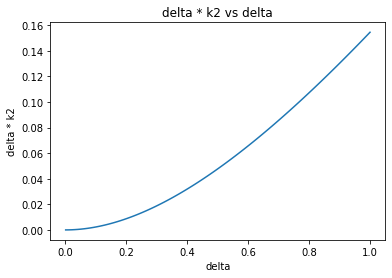

In [50]:
f11 = lambda x: float((delta * k2_solved).subs(k1, k1_solved).subs(delta, x).subs(d, 0.6).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f11(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k2 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k2")
plt.show()

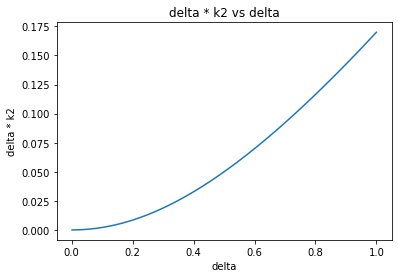

In [51]:
f12 = lambda x: float((delta * k2_solved).subs(k1, k1_solved).subs(delta, x).subs(d, 0.3).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f12(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k2 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k2")
plt.show()

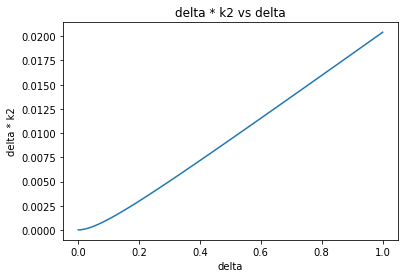

In [52]:
f13 = lambda x: float((delta * k2_solved).subs(k1, k1_solved).subs(delta, x).subs(d, 0.3).subs(c, 0.1))
plt.plot(np.linspace(0.001, 1, 100), [f13(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k2 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k2")
plt.show()

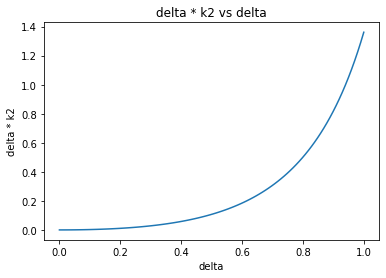

In [53]:
f14 = lambda x: float((delta * k2_solved).subs(k1, k1_solved).subs(delta, x).subs(d, 0.3).subs(c, 1000.0))
plt.plot(np.linspace(0.001, 1, 100), [f14(x) for x in np.linspace(0.001, 1, 100)])
plt.title("delta * k2 vs delta")
plt.xlabel("delta")
plt.ylabel("delta * k2")
plt.show()

# $k_1/d$ in $d$

In [54]:
diff(k1_solved/d, d)

(c*delta*(2*d - 2) + c*delta*(2*d - 2)*(c*delta*(1 - d)**2 - c + delta)/sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2))/(2*d*delta) - (c*delta*(1 - d)**2 - c + delta + sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2))/(2*d**2*delta)

The term on the right, including the minus sign, is negative. We turn to the term on the left, which if we let $g = c\delta(1-d)^2 - c + \delta$, is:

In [55]:
(c*delta*(d-1) * (1 + g/sqrt(4*c*delta+g**2)))/(d*delta)

c*(d - 1)*(g/sqrt(4*c*delta + g**2) + 1)/d

We saw earlier that $1 + \frac{g}{\sqrt{4c\delta+g^2}} > 0$ is positive so the term as a whole is negative. This implies that the derivative is negative, and so $k_1/d$ is decreasing in $d$. We can check:

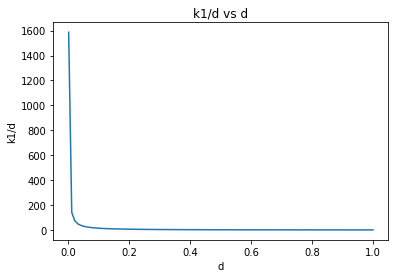

In [56]:
f15 = lambda x: float((k1_solved/d).subs(delta, 0.9).subs(d, x).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f15(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k1/d vs d")
plt.xlabel("d")
plt.ylabel("k1/d")
plt.show()

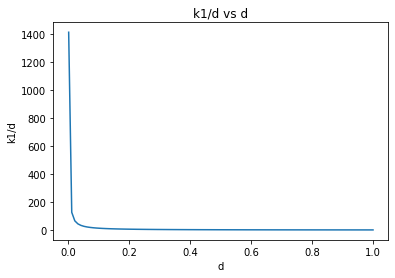

In [57]:
f16 = lambda x: float((k1_solved/d).subs(delta, 0.5).subs(d, x).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f16(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k1/d vs d")
plt.xlabel("d")
plt.ylabel("k1/d")
plt.show()

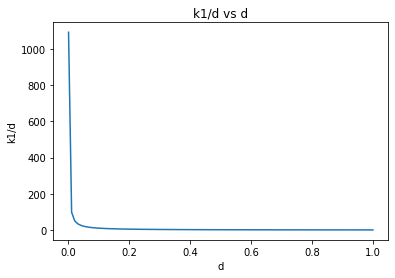

In [58]:
f17 = lambda x: float((k1_solved/d).subs(delta, 0.9).subs(d, x).subs(c, 0.1))
plt.plot(np.linspace(0.001, 1, 100), [f17(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k1/d vs d")
plt.xlabel("d")
plt.ylabel("k1/d")
plt.show()

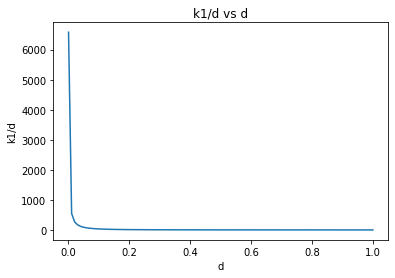

In [59]:
f18 = lambda x: float((k1_solved/d).subs(delta, 0.9).subs(d, x).subs(c, 100.0))
plt.plot(np.linspace(0.001, 1, 100), [f18(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k1/d vs d")
plt.xlabel("d")
plt.ylabel("k1/d")
plt.show()

# $k_2/d$ in $d$

In [60]:
k2_solved/d

c*delta*k_1*(1 - d)/(c*d*delta - c*delta + c + delta*k_1)

It should be noted, first, that if we take the derivative of $k_1$ with respect to $d$:

In [61]:
diff(k1_solved, d)

(c*delta*(2*d - 2) + c*delta*(2*d - 2)*(c*delta*(1 - d)**2 - c + delta)/sqrt(4*c*delta + (c*delta*(1 - d)**2 - c + delta)**2))/(2*delta)

Then by the argument from the $k_1/d$ case, this is negative, so $k_1$ is itself decreasing in $d$.

Take the reciproval of $k_2/d$:

In [62]:
1/(k2_solved/d)

(c*d*delta - c*delta + c + delta*k_1)/(c*delta*k_1*(1 - d))

This separates into the following expression:

In [63]:
1/k1 * (1/(delta*(1-d)) - 1) + 1/(c*(1-d))

(-1 + 1/(delta*(1 - d)))/k_1 + 1/(c*(1 - d))

We know the term on the right is increasing in $d$ so we focus on the term on the left:

In [64]:
simplify((-1 + 1/(delta*(1-d)))/k1)

(-d*delta + delta - 1)/(delta*k_1*(d - 1))

This can be rewritten as:

In [65]:
(1 - delta + d*delta) / (delta * k1 * (1 -d))

(d*delta - delta + 1)/(delta*k_1*(1 - d))

$k_1$ is decreasing in $d$ and $(1-d)$ is decreasing in $d$. They are both positive so their product is also decreasing in $d$. Thus, the denominator is decreasing in $d$.

The numerator is clearly increasing in $d$ and can be rewritten as $1 + \delta(d-1) = 1 - \delta(1-d)$. $\delta(1-d) < 1$ so this expression is positive. Since the denominator of the fraction is also positive, this means we can take the fraction as $\frac{a}{b} = a * \frac{1}{b}$ where $a$ and $\frac{1}{b}$ are both positive expressions increasing in $d$. Thus, $\frac{a}{b}$ is increasing in $d$ and so this whole fraction is increasing in $d$, meaning the entire reciprocal does, implying that $k_2/d$ is decreasing in $d$. We can check:

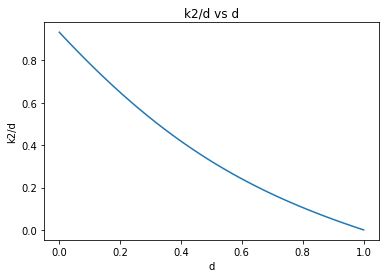

In [66]:
f19 = lambda x: float((k2_solved/d).subs(k1, k1_solved).subs(delta, 0.9).subs(d, x).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f19(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k2/d vs d")
plt.xlabel("d")
plt.ylabel("k2/d")
plt.show()

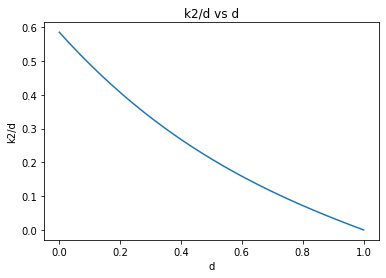

In [67]:
f20 = lambda x: float((k2_solved/d).subs(k1, k1_solved).subs(delta, 0.5).subs(d, x).subs(c, 1))
plt.plot(np.linspace(0.001, 1, 100), [f20(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k2/d vs d")
plt.xlabel("d")
plt.ylabel("k2/d")
plt.show()

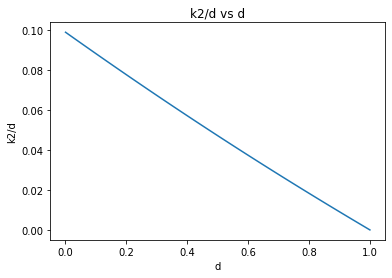

In [68]:
f21 = lambda x: float((k2_solved/d).subs(k1, k1_solved).subs(delta, 0.9).subs(d, x).subs(c, 0.1))
plt.plot(np.linspace(0.001, 1, 100), [f21(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k2/d vs d")
plt.xlabel("d")
plt.ylabel("k2/d")
plt.show()

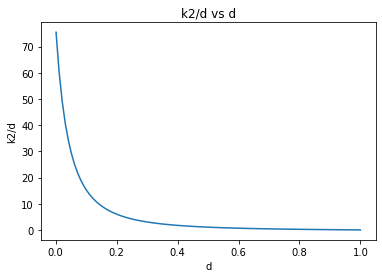

In [69]:
f22 = lambda x: float((k2_solved/d).subs(k1, k1_solved).subs(delta, 0.9).subs(d, x).subs(c, 1000))
plt.plot(np.linspace(0.001, 1, 100), [f22(x) for x in np.linspace(0.001, 1, 100)])
plt.title("k2/d vs d")
plt.xlabel("d")
plt.ylabel("k2/d")
plt.show()